# Descriptors
Image Patch -- Just use the pixel values of the patch
- Perfectly fine if geometry and appearance is unchanged
- A downsampling is useful to make it simple, fast, robust to small affine transforms.

Image Gradients
- Feature is invariant to absolute intensity values
- Sensitive to deformations

Color histogram
- Invariant to changes in scale and rotation
- Sensitive to spatial layout

Spatial histograms
- Retains rough spatial layout
- Some invariance to deformations
- Orientation normalization may useful -- Use the dominant image gradient direction to normalize the orientation of the patch

#### Haar Wavelets

https://shodhganga.inflibnet.ac.in/bitstream/10603/20682/12/12_chapter%203.pdf

http://mathworld.wolfram.com/HaarFunction.html

http://www.faculty.jacobs-university.de/llinsen/teaching/320491/Lecture05.pdf

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [39]:
illidan = cv2.imread('dataset/illidan.jpg')
illidan = cv2.resize(illidan, (512, 512))

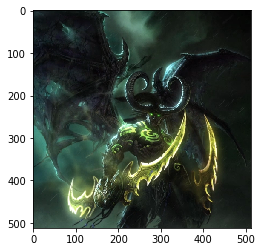

In [40]:
plt.imshow(illidan)

In [30]:
def downsampling(img, scale, gsigma = 1, ksize = None):
    if scale == 1:
        return img
    if ksize and gsigma > 0:
        img = cv2.GaussianBlur(img, ksize, gsigma)
    m = img.shape[0]
    n = img.shape[1]
    vdel = img.reshape(-1, 3)[:m // scale * scale * n // scale * scale, :].reshape((-1, scale, 3))[:,0,:]
    return vdel.reshape((m // scale, -1, 3))[:, : n//scale, :]

In [96]:
def haar_wavelets_base(img, scale, base):
    if scale == 1:
        base['bottomleft'] = img
        return img / 255
    
    output = np.zeros_like(img, dtype = float)
    
    m = img.shape[0] // 2
    n = img.shape[1] // 2
    
    topleft = np.array([[-1, -1], [1, 1]]) / 2
    topright = np.array([[-1, 1],[1, -1]]) / 2
    bottomleft = np.array([[1, 1], [1, 1]]) / 2
    bottomright = np.array([[1, -1], [1, -1]]) / 2
    
    base['bottomleft'] = {}
    output[m:, :n, :] = haar_wavelets_base(downsampling(cv2.filter2D(img, cv2.CV_32F, bottomleft), 2), scale - 1, base['bottomleft'])
    base['topleft'] = output[:m, :n, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, topleft), 2)
    base['topright'] = output[:m, n:, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, topright), 2)
    base['bottomright'] = output[m:, n:, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, bottomright), 2)
    
    return output
    

In [97]:
base = {}
scale = 3
haar = haar_wavelets_base(illidan, scale, base)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


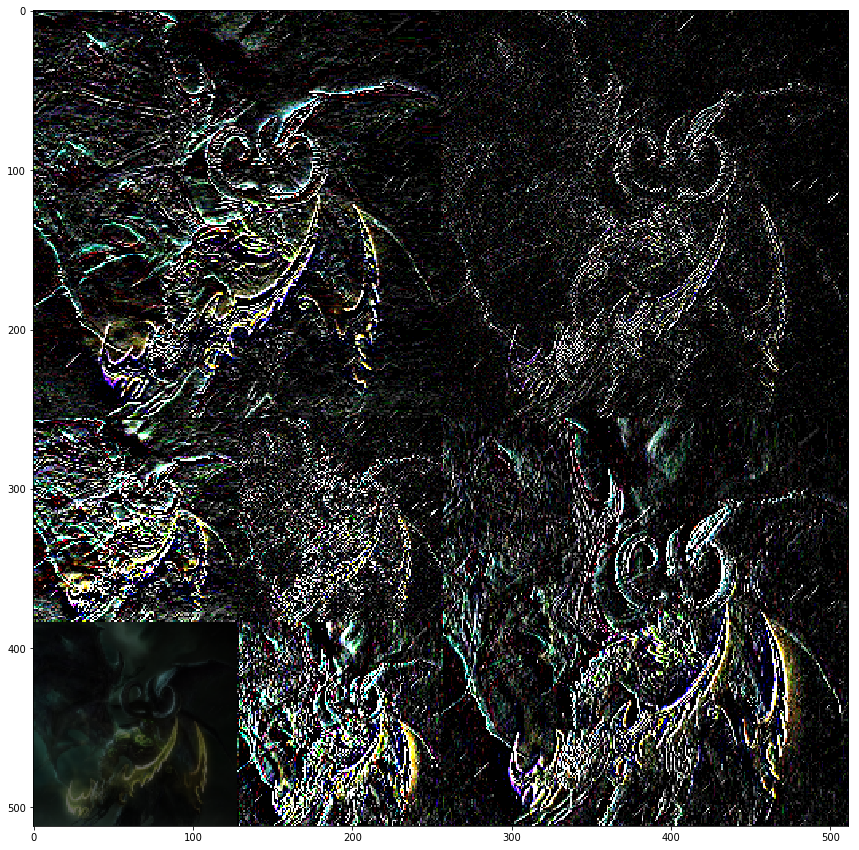

In [104]:
fig = plt.figure(figsize = (15, 15))
plt.imshow(haar / 10)

In [99]:
def examineEnergy(haarDict, output):
    for k, v in haarDict.items():
        if isinstance(v, dict):
            examineEnergy(v, output)
        else:
            output.append(np.sum(v ** 2))

In [100]:
output = []
examineEnergy(base, output)
output[0] = output[0] * 255

In [102]:
output

[755379555840.0,
 23412536.0,
 8316310.5,
 47475864.0,
 13751153.0,
 3615532.8,
 26689954.0]

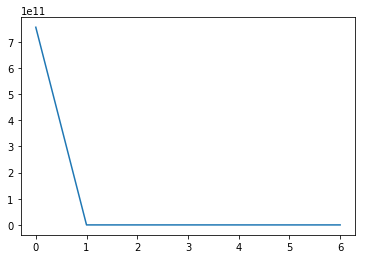

In [101]:
plt.plot(output)

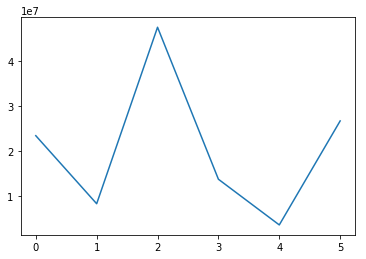

In [103]:
plt.plot(output[1:])

#### Gabor Filters
1D samples
$$e^{-\frac{x^2}{2\sigma^2}} \sin(2\pi\omega x) \text{ and } e^{-\frac{x^2}{2\sigma^2}} \cos(2\pi\omega x)$$

In [148]:
x = np.linspace(-125, 125, 251)

In [263]:
gabor1dO = lambda sigma, omega: np.exp(- x ** 2 / sigma ** 2 / 2) * np.sin(2 * np.pi * x * omega)
gabor1dE = lambda sigma, omega: np.exp(- x ** 2 / sigma ** 2 / 2) * np.cos(2 * np.pi * x * omega)

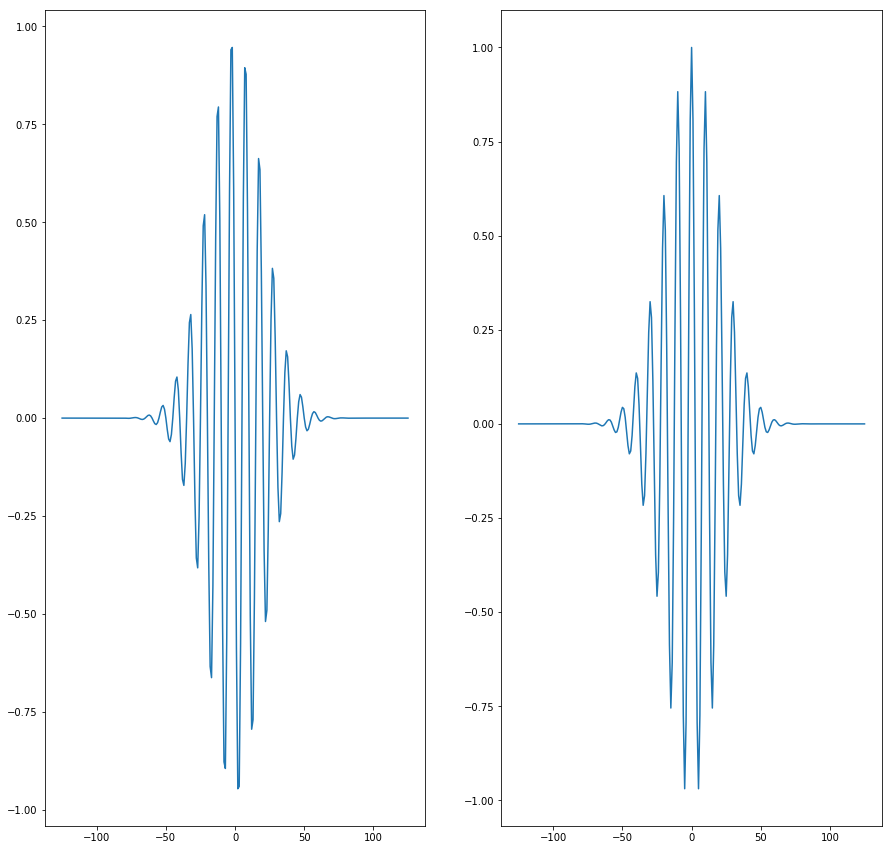

In [264]:
f, axes = plt.subplots(1, 2, figsize = (15, 15))
axes[0].plot(x, gabor1dO(20, 0.9))
axes[1].plot(x, gabor1dE(20, 0.9))

2D Filter
$$e^{-\frac{x^2 + y^2}{2 \sigma^2}} \cos(2\pi (k_x x + k_y y))$$

In [285]:
y, x =  np.ogrid[-30:30, -30:30]

In [276]:
gabor2d = lambda sigma, kx, ky, x, y: np.exp(- (x ** 2 + y ** 2) / 2 / sigma ** 2) * np.cos(2 * np.pi * (kx * x + ky * y))

In [269]:
from mpl_toolkits.mplot3d import Axes3D

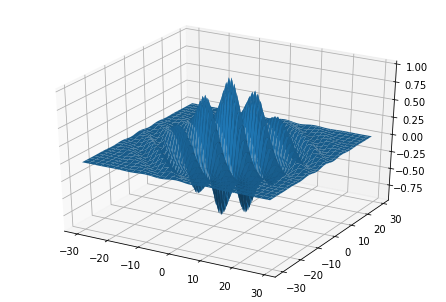

In [303]:
z = gabor2d(10, 0.9, 0.9, x, y)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, z)

## Scale Invariant Feature Transform
> The features are invariant to image scale and rotation, and are shown to provide robust matching across a a substantial range of affine distortion, change in 3D viewpoint, addition of noise, and change in illumination.

The major stages are:
1. Scale-space extrema detection
2. Keypoint Localization
3. Orientation Assignment
4. Keypoint Descriptor

> An important aspect of this approach is that it generates large numbers of features that densely cover the image over the full range of scales and locations. A typical image of size 500x500 pixels will give rise to about 2000 stable features (although this number depends on both image content and choices for various parameters). The quantity of features is particularly important for object recognition, where the ability to detect small objects in cluttered backgrounds requires that at least 3 features be correctly matched from each object for reliable identification. <br>
For image matching and recognition, SIFT features are first extracted from a set of reference images and stored in a database. A new image is matched by individually comparing each feature from the new image to this previous database and finding candidate matching features based on Euclidean distance of their feature vectors. <br>
The keypoint descriptors are highly distinctive, which allows a single feature to find its correct match with good probability in a large database of features. However, in a cluttered image, many features from the background will not have any correct match in the database, giving rise to many false matches in addition to the correct ones. The correct matches can be filtered from the full set of matches by identifying subsets of keypoints that agree on the object and its location, scale, and orientation in the new image. The probability that several features will agree on these parameters by chance is much lower than the probability that any individual feature match will be in error. The determination of these consistent clusters
can be performed rapidly by using an efficient hash table implementation of the generalized Hough transform. <br>
Each cluster of 3 or more features that agree on an object and its pose is then subject to further detailed verification. First, a least-squared estimate is made for an affine approximation to the object pose. Any other image features consistent with this pose are identified, and outliers are discarded. Finally, a detailed computation is made of the probability that a
particular set of features indicates the presence of an object, given the accuracy of fit and number of probable false matches. Object matches that pass all these tests can be identified as correct with high confidence.

#### 1. Scale space extrema detection
The scale space of an image is defined as a function $L(x, y, \sigma)$ such that
$$L(x, y, \sigma) = G(x, y, \sigma) * I(x, y)$$
To efficiently detect stable keypoint locations in scale space, the difference-of-Gaussian function D(x, y, σ) is proposed, such that
$$D(x, y, \sigma) = (G(x, y, k\sigma) - G(x, y, \sigma)) * I(x, y) = L(x, y, k\sigma) - L(x, y, \sigma)$$
![](dataset/dog.png)

Moreover, DoG provides a close approximation to the __scale-normalized__ LoG $\sigma^2 \nabla^2 G$ ($\sigma^2$ is required for the ture scale invariance). It's shown that the maxima
and minima of $\sigma^2\nabla^2G$ produce the most stable image features compared to a range of other possible image functions, such as the gradient, Hessian, or Harris corner function. The relationship between $D$ and $\sigma^2\nabla^2G$ can be got from the heat diffusion equation
$$\frac{\partial}{\partial \sigma} G = \sigma\nabla^2 G$$
Which means that
$$\sigma\nabla^2 G = \frac{\partial}{\partial \sigma} G \approx \frac{G(x, y, k\sigma) - G(x, y, \sigma)}{k\sigma - \sigma}$$
And therefore
$$G(x, y, k\sigma) - G(x, y, \sigma) \approx (k - 1)\sigma^2\nabla^2G$$
The factor (k − 1) in the equation is a constant over all scales and therefore does not influence extrema location. The approximation error will go to zero as k goes to 1, but in practice we have found that the approximation has almost no impact on the stability of extrema detection or localization for even significant differences in scale, such as $k = \sqrt{2}$
An efficient approach to construction of D(x, y, σ) is shown in Figure 1. The initial image is incrementally convolved with Gaussians to produce images separated by a constant factor k in scale space, shown stacked in the left column. We choose to divide each octave of scale space (i.e., doubling of σ) into an integer number, s, of intervals, so $k = \sqrt{2}$.

We must produce s + 3 images in the stack of blurred images for each octave, so that final extrema detection covers a complete octave. Adjacent image scales are subtracted to produce the difference-of-Gaussian images shown on the right. Once a complete octave has been processed, we resample the Gaussian image that has twice the initial value of σ (it will be 2 images from the top of the stack) by taking every second pixel in each row and column. The accuracy of sampling relative to σ is no different than for the start of the previous octave, while computation is greatly reduced.

In [552]:
image = cv2.imread('dataset/sylvanas.jpg', 0).astype(float)

In [553]:
def CreateDogSpace(img, noo, nos, sigma0, ksize, presmooth):
    output = []
    pre = cv2.GaussianBlur(img, (3, 3), presmooth)
    pre = cv2.resize(pre, dsize = (0, 0), fx = 2, fy = 2, interpolation = cv2.INTER_LINEAR)
    sigs = [0] * (nos + 2)
    pres = 0
    for i in range(nos + 2):
        temp = sigma0 * np.power(2, i / nos)
        sigs[i] = np.sqrt(temp ** 2 - pres ** 2)
        pres = temp
    for i in range(noo):
        output.append([])
        for s in range(nos + 2):
            temp = cv2.GaussianBlur(pre, ksize, sigs[s])
            output[i].append(temp - pre)
            pre = temp
        pre = cv2.resize(output[i][-1], dsize = (0,0), fx = 0.5, fy = 0.5, interpolation = cv2.INTER_NEAREST)
    return output

In [554]:
output = CreateDogSpace(image, 4, 5, 1.6, (3, 3), 0.5)

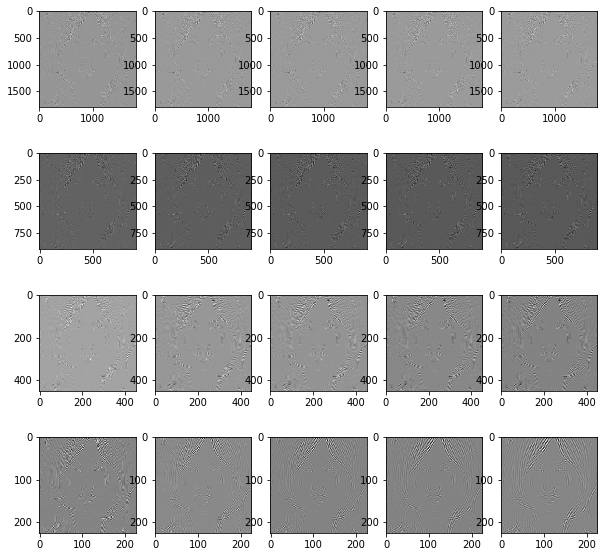

In [555]:
f, axes = plt.subplots(4, 5, figsize = (10, 10))
for i in range(4):
    for j in range(5):
        axes[i][j].imshow(output[i][j], cmap = 'gray')

#### Local extrema detection
Unfortunately, it turns out that there is no minimum spacing of samples that will detect all extrema, as the extrema can be arbitrarily close together. 

Therefore, we must settle for a solution that trades off efficiency with completeness. In fact, as might be expected and is confirmed by our experiments, extrema that are close together are quite unstable to small perturbations of the image. We can determine the best choices experimentally by studying a range of sampling frequencies and using those that provide the most reliable results under a realistic simulation of the matching task. 

Of course, if we pre-smooth the image before extrema detection, we are effectively discarding the highest spatial frequencies. Therefore, to make full use of the input, the image can be expanded to create more sample points than were present in the original. We double the size of the input image using linear interpolation prior to building the first level of the pyramid. While the equivalent operation could effectively have been performed by using sets of subpixel-offset filters on the original image, the image doubling leads to a more efficient implementation. We assume that the original image has a blur of at least σ = 0.5 (the minimum needed to prevent significant aliasing), and that therefore the doubled image has σ = 1.0 relative to its new pixel spacing. This means that little additional smoothing is needed prior to creation of the first octave of scale space. The image doubling increases the number of stable keypoints by almost a factor of 4, but no significant further improvements
were found with a larger expansion factor.

In [719]:
def LocalExtrema(octaves, threshold):
    threshold = 0.5 * threshold / len(octaves[1]) * 255
    extrema = []
    for t in range(len(octaves)):
        for s in range(1, len(octaves[t]) - 1):
            cur = octaves[t][s]
            pre = octaves[t][s - 1]
            next = octaves[t][s + 1]
            m, n = np.where(np.abs(cur[1:-1, 1:-1]) > threshold)
            for i, j in zip(m + 1, n + 1):
                if cur[i][j] > cur[i - 1][j - 1] and cur[i][j] > cur[i - 1][j] and cur[i][j] > cur[i - 1][j + 1] and \
                cur[i][j] > cur[i][j - 1] and cur[i][j] > cur[i][j + 1] and cur[i][j] > cur[i + 1][j - 1] and \
                cur[i][j] > cur[i + 1][j] and cur[i][j] > cur[i + 1][j + 1]:
                    extrema.append([t, s, i, j])
                elif cur[i][j] < cur[i - 1][j - 1] and cur[i][j] < cur[i - 1][j] and cur[i][j] < cur[i - 1][j + 1] and \
                cur[i][j] < cur[i][j - 1] and cur[i][j] < cur[i][j + 1] and cur[i][j] < cur[i + 1][j - 1] and \
                cur[i][j] < cur[i + 1][j] and cur[i][j] < cur[i + 1][j + 1]:
                    extrema.append([t, s, i, j])
    return extrema

In [720]:
extremas = LocalExtrema(output, 0.04)

In [721]:
extremas = np.array(extremas)

In [722]:
extremas.shape[0]

38701

In [723]:
extremas2 = (2 ** extremas[:, 0, np.newaxis]) * extremas[:, -2:]

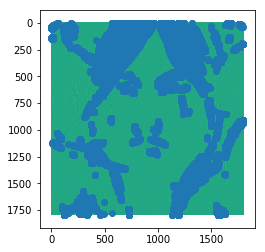

In [724]:
plt.imshow(output[0][1])
plt.scatter(px, py)

#### Accurate keypoint localization
Once a keypoint candidate has been found by comparing a pixel to its neighbors, the next step is to perform a detailed fit to the nearby data for location, scale, and ratio of principal curvatures. 
Recall the Second Order Taylor Expension
$$D(\mathbf{x}) = D + \mathbf{x}^T\frac{\partial D}{\partial \mathbf{x}} + \frac{1}{2}\mathbf{x}^T \frac{\partial^2 D}{\partial \mathbf{x}^2} \mathbf{x}$$
The location of the extrema will be 
$$\hat{\mathbf{x}} = - \frac{\partial^2 D}{\partial \mathbf{x}^2}^{-1} \frac{\partial D}{\partial \mathbf{x}}$$
And then
$$D(\mathbf{\hat{x}}) = D + \frac{1}{2} \frac{\partial D}{\partial  \mathbf{x}} \hat{\mathbf{x}}$$